<a href="https://colab.research.google.com/github/anosharahim/deep-learning/blob/master/VGG_Face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#implementing with help from
#https://colab.research.google.com/drive/1AwCzp-7MywbaJWYjA6Rli4Z5JHKrYHQN#scrollTo=qhpJ-rBayzcc

%tensorflow_version 1.x
!pip install keras-vggface

TensorFlow 1.x selected.


In [ ]:
import pandas as pd
import os
import numpy as np
import random 

import keras
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

Using TensorFlow backend.


## Load Data


In [34]:
#load data from gdrive
train_npz = np.load("/content/drive/MyDrive/Capstone/datasets/train.npz")
test_npz = np.load("/content/drive/MyDrive/Capstone/datasets/test.npz")

x_train = train_npz["arr_0"]
y_train = train_npz["arr_1"]
x_test = test_npz["arr_0"]
y_test = test_npz["arr_1"]

#add 2 more channels to grayscale image to imitate rgb
x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
x_test = np.repeat(x_test[..., np.newaxis], 3, -1)

#split test set into validation and test set 
#x_val, x_test, y_val ,y_test = train_test_split(x_test,y_test, test_size=0.3)

#print('Train -- ', x_train.shape, y_train.shape)
#print('Val -- ', x_val.shape, y_val.shape)
print('Test -- ', x_test.shape, y_test.shape)

Test --  (7178, 48, 48, 3) (7178,)


[0 1 2 3 4 5 6] [ 958  111 1024 1774 1233 1247  831]
[191.6  22.2 204.8 354.8 246.6 249.4 166.2]


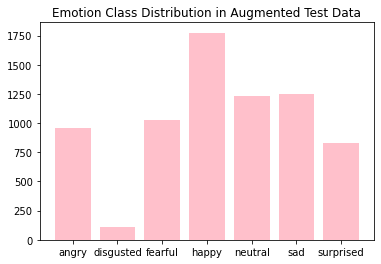

In [47]:
import matplotlib.pyplot as plt
emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}
values, counts_ = np.unique(y_test, return_counts=True)
plt.title("Emotion Class Distribution in Augmented Test Data")
plt.bar(emotion_dictionary.keys(),counts_, color = 'pink')

print(values, counts_)
print(counts_*.2)

## Load Model 


In [ ]:
from keras_vggface.vggface import VGGFace

In [ ]:
!pip install 'h5py==2.10.0' --force-reinstall

In [ ]:
pic_size = 197
vgg_face = VGGFace(model='vgg16', include_top=False, input_shape=(pic_size,pic_size,3))
print(vgg_face.summary())

In [ ]:
EPOCHS = 50
BS = 128
DROPOUT_RATE = 0.5
FROZEN_LAYER_NUM = 19

ADAM_LEARNING_RATE = 0.001
SGD_LEARNING_RATE = 0.01
SGD_DECAY = 0.0001

last_layer = vgg_face.get_layer('pool5').output
x = keras.layers.Flatten(name='flatten')(last_layer)
x = keras.layers.Dropout(DROPOUT_RATE)(x)
x = keras.layers.Dense(4096, activation='relu', name='fc6')(x)
x = keras.layers.Dropout(DROPOUT_RATE)(x)
x = keras.layers.Dense(1024, activation='relu', name='fc7')(x)

for i in range(FROZEN_LAYER_NUM):
    vgg_face.layers[i].trainable = False

print(vgg_face.get_layer('pool5').trainable)

out = keras.layers.Dense(7, activation='softmax', name='classifier')(x)

model = keras.engine.Model(vgg_face.input, out)


optim = keras.optimizers.Adam(lr=ADAM_LEARNING_RATE, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
#optim = keras.optimizers.Adam(lr=0.0005, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
sgd = keras.optimizers.SGD(lr=SGD_LEARNING_RATE, momentum=0.9, decay=SGD_DECAY, nesterov=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_acc',mode='max',factor=0.5, patience=10, min_lr=0.00001, verbose=1)

model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['accuracy'])

False


In [ ]:
def get_datagen(dataset, aug=False):
    if aug:
        datagen = ImageDataGenerator(
                            rescale=1./255,
                            featurewise_center=False,
                            featurewise_std_normalization=False,
                            rotation_range=10,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            zoom_range=0.1,
                            horizontal_flip=True)
    else:
        datagen = ImageDataGenerator(rescale=1./255)

    return datagen.flow_from_directory(
            dataset,
            target_size=(197, 197),
            color_mode='rgb',
            shuffle = True,
            class_mode='categorical',
            batch_size=BS)

In [68]:
import shutil
import math 

train_path = '/content/drive/MyDrive/Capstone/FER2013/train/'
val_path = '/content/drive/MyDrive/Capstone/FER2013/val/'
test_path = '/content/drive/MyDrive/Capstone/FER2013/test/'


#emotion_dictionary = {'angry':0, 'disgusted':1, 'fearful':2, 'happy':3, 'neutral':4, 'sad':5, 'surprised':6}
#emotion = os.listdir(test_path+'/fearful')
#emotion = emotion [:math.floor(len(emotion)*.8)]

#for i in emotion: 
 # shutil.move('/content/drive/MyDrive/Capstone/FER2013/test/fearful/'+i, '/content/drive/MyDrive/Capstone/FER2013/val/fearful/'+i)



In [70]:
tr = get_datagen(train_path)
val = get_datagen(val_path)
ts = get_datagen(test_path)

Found 28709 images belonging to 7 classes.
Found 6069 images belonging to 7 classes.
Found 1109 images belonging to 7 classes.


In [ ]:
history = model.fit_generator(
    generator = tr,
    validation_data= val, 
    steps_per_epoch= 28709// BS,
    validation_steps= 3509 // BS,
    shuffle= True,
    epochs= 100,
    callbacks= [rlrop],
    use_multiprocessing=True,
) 

Epoch 1/100


/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 210 could not be retrieved. It could be because a worker has died.
  UserWarning)


  1/224 [..............................] - ETA: 7:44:41 - loss: 1.9330 - accuracy: 0.1484

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 170 could not be retrieved. It could be because a worker has died.
  UserWarning)


  2/224 [..............................] - ETA: 7:20:06 - loss: 1.9406 - accuracy: 0.1641

/tensorflow-1.15.2/python3.7/keras/utils/data_utils.py:616: UserWarning: The input 26 could not be retrieved. It could be because a worker has died.
  UserWarning)
